In [1]:
# !pip install scikit-plot

# Import Necessary Libraries


In [1]:
import numpy as np
import os
import pandas as pd
import cv2
from tqdm import tqdm
import io

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import shuffle # Shuffle arrays or sparse matrices in a consistent way
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential, load_model
import tensorflow

from sklearn.metrics import classification_report, confusion_matrix
import scikitplot as skplt

# Reading the Dataset and analysis

In [2]:
train_dir = 'F:\\Ml files\\brain tumor classification\\Data\\Training\\'

test_dir = 'F:\\Ml files\\brain tumor classification\\Data\\Testing\\'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

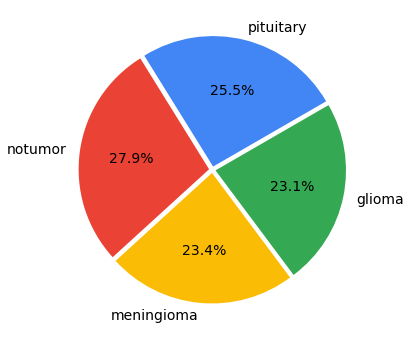

In [3]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len([x for x in train_labels if x=='pituitary']),
         len([x for x in train_labels if x=='notumor']),
         len([x for x in train_labels if x=='meningioma']),
         len([x for x in train_labels if x=='glioma'])],
        labels=['pituitary','notumor', 'meningioma', 'glioma'],
        colors=colors, autopct='%.1f%%', explode=(0.025,0.025,0.025,0.025),
        startangle=30);

# Defining Labels and loading dataset


In [4]:
X_train = [] #Training Dataset
Y_train = [] #Training Labels
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

image_size=150

for i in labels:
    folderPath = os.path.join('F:\\Ml files\\brain tumor classification\\Data\\', 'Training', i)
    for j in tqdm(os.listdir(folderPath)):
        image = cv2.imread(os.path.join(folderPath, j))
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(i)
        
        
for i in labels:
    folderPath = os.path.join('F:\\Ml files\\brain tumor classification\\Data\\', 'Testing', i) # Join two or more pathname components
    for j in tqdm(os.listdir(folderPath)):
        image = cv2.imread(os.path.join(folderPath, j))
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(i)
        
#Image and Label is appended as list, now is to be converted into array
X_train = np.array(X_train)
Y_train = np.array(Y_train)


100%|███████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 203.73it/s]


In [5]:
X_train.shape #No of sample = 7023

(7023, 150, 150, 3)

In [6]:
# Shuffling data
X_train, Y_train = shuffle(X_train, Y_train, random_state=42)

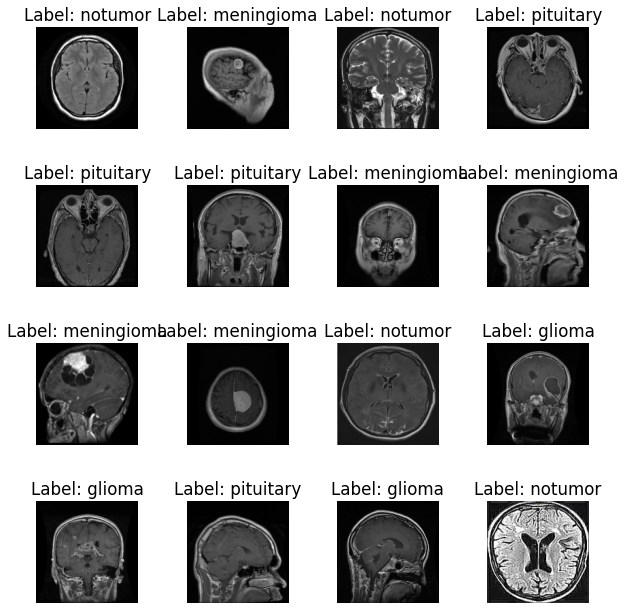

In [7]:
grid_width = 4
grid_height = 4
f, ax = plt.subplots(grid_width, grid_height)
f.set_size_inches(8, 8)

img_idx = 0
for i in range(0, grid_width):
    for j in range(0, grid_height):
        ax[i][j].axis('off')
        ax[i][j].set_title('Label: '+Y_train[img_idx])
        ax[i][j].imshow(X_train[img_idx])
        img_idx += 1

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0.55)  

# Splitting data into : Train, Test, Valid as 70, 20, 10 ratio


In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

# Converting String Label to categorical


In [9]:
y_train_new = []
y_valid_new = []
y_test_new = []

for i in Y_train:
    y_train_new.append(labels.index(i))#Converting String Label to integer i.e
                                       # glioma ---> 0, meningioma---> 1, notumor ---> 2, pituitary ---> 3
Y_train = to_categorical(y_train_new) #Converts a class vector (integers) to binary class matrix

for i in Y_valid:
    y_valid_new.append(labels.index(i))

Y_valid = to_categorical(y_valid_new)

for i in Y_test:
    y_test_new.append(labels.index(i))

Y_test = to_categorical(y_test_new)

# MobileNet Model


In [10]:
from tensorflow.keras.applications import MobileNet
base_model=MobileNet(weights='imagenet',include_top=False,input_shape = (150,150,3))
model = tensorflow.keras.Sequential([
    base_model,
    tensorflow.keras.layers.Conv2D(128, 3, activation='relu'),
    tensorflow.keras.layers.Dropout(0.2),
    tensorflow.keras.layers.GlobalAveragePooling2D(),
    tensorflow.keras.layers.Dense(4, activation='softmax')
    ])

In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 4, 4, 1024)        3228864   
_________________________________________________________________
conv2d (Conv2D)              (None, 2, 2, 128)         1179776   
_________________________________________________________________
dropout (Dropout)            (None, 2, 2, 128)         0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 4)                 516       
Total params: 4,409,156
Trainable params: 4,387,268
Non-trainable params: 21,888
_________________________________________________________________


# Scaling Features : Train, Valid and Test

In [12]:
# Scaling Train, Valid and Test Features
X_train_scaled = X_train.astype('float32')
X_valid_scaled = X_valid.astype('float32')
X_test_scaled = X_test.astype('float32')


X_train_scaled /= 255
X_valid_scaled /= 255
X_test_scaled /= 255

# Training the model

In [27]:
history = model.fit(x=X_train_scaled, y=Y_train,
                   validation_data=(X_valid_scaled, Y_valid),
                   batch_size=64,
                   epochs=28,
                   verbose=1)

Epoch 1/28
79/79 [==============================] - 10s 123ms/step - loss: 0.0301 - accuracy: 0.9941 - val_loss: 0.1530 - val_accuracy: 0.9573
Epoch 2/28
79/79 [==============================] - 10s 124ms/step - loss: 0.0113 - accuracy: 0.9962 - val_loss: 0.0992 - val_accuracy: 0.9804
Epoch 3/28
79/79 [==============================] - 10s 125ms/step - loss: 0.0143 - accuracy: 0.9964 - val_loss: 0.1316 - val_accuracy: 0.9751
Epoch 4/28
79/79 [==============================] - 10s 124ms/step - loss: 0.0133 - accuracy: 0.9958 - val_loss: 0.2769 - val_accuracy: 0.9324
Epoch 5/28
79/79 [==============================] - 10s 125ms/step - loss: 0.0045 - accuracy: 0.9982 - val_loss: 0.0760 - val_accuracy: 0.9840
Epoch 6/28
79/79 [==============================] - 10s 123ms/step - loss: 0.0061 - accuracy: 0.9980 - val_loss: 0.0695 - val_accuracy: 0.9751
Epoch 7/28
79/79 [==============================] - 10s 125ms/step - loss: 0.0045 - accuracy: 0.9994 - val_loss: 0.0535 - val_accuracy: 0.9858

# Accuracy and Loss Visualization

ValueError: x and y must have same first dimension, but have shapes (30,) and (28,)

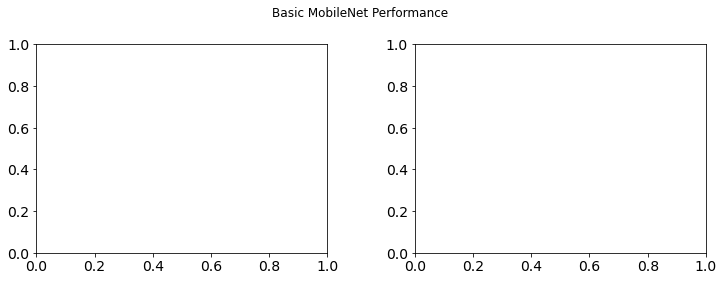

In [28]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic MobileNet Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")


# Getting model predictions : Classification Report

In [29]:
# Getting model predictions
test_predictions = model.predict(X_test_scaled)
preds = np.argmax(test_predictions, axis=1)
actual_label = np.argmax(Y_test, axis=1)
print(classification_report(actual_label, preds))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       310
           1       0.97      0.96      0.97       326
           2       0.99      0.95      0.96       419
           3       0.93      0.99      0.96       350

    accuracy                           0.97      1405
   macro avg       0.97      0.97      0.97      1405
weighted avg       0.97      0.97      0.97      1405



# Showing Confusion Matrix

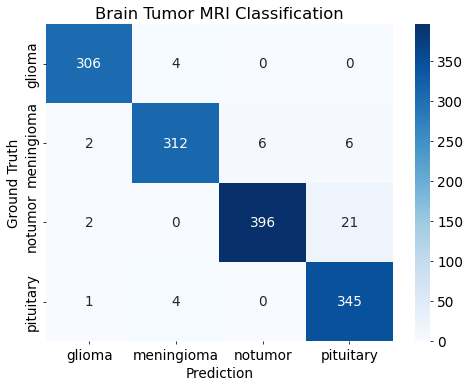

In [30]:
cnf = confusion_matrix(actual_label, preds)
plt.figure(figsize=(8,6), dpi=70, facecolor='w', edgecolor='k')
ax = sns.heatmap(cnf, cmap='Blues', annot=True, fmt = 'd', xticklabels=labels, yticklabels=labels)
plt.title('Brain Tumor MRI Classification')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.show(ax)

ROC AUC score: 0.978914447615028


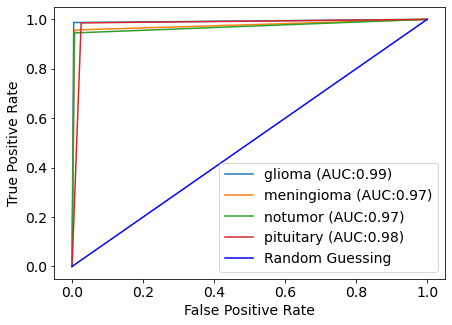

In [31]:
# set plot figure size
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import *


fig, c_ax = plt.subplots(1,1, figsize = (7, 5))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(labels):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)
print('ROC AUC score:', multiclass_roc_auc_score(actual_label,preds))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()


In [32]:
def report_generate(Y_test, predictions):
  report = pd.DataFrame(classification_report(y_true = Y_test, y_pred = predictions, output_dict=True)).transpose()
  report = report.rename(index={'0': 'glioma','1':'meningioma','2':'notumor',
                                '3':'pituitary'})
  report[['precision','recall','f1-score']]=report[['precision','recall','f1-score']].apply(lambda x: round(x*100,2))
  report=report.drop(["support"],axis=1)
  columns = ['precision','recall','f1-score']
  report.columns = columns
  plt = report.plot(kind='bar',figsize=(12,6))
  
  plot=plt.tick_params(rotation=40)
  
  return plot,report

(None,
               precision  recall  f1-score
 glioma            98.39   98.71     98.55
 meningioma        97.50   95.71     96.59
 notumor           98.51   94.51     96.47
 pituitary         92.74   98.57     95.57
 accuracy          96.73   96.73     96.73
 macro avg         96.79   96.87     96.80
 weighted avg      96.81   96.73     96.73)

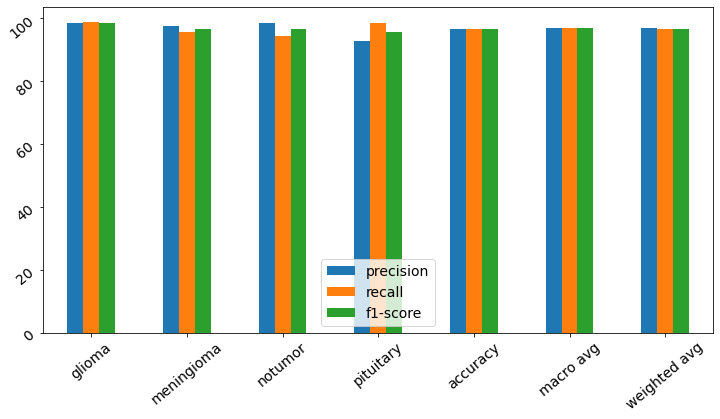

In [33]:
report_generate(actual_label,preds)

# Visualizing Model Predictions with Confidence

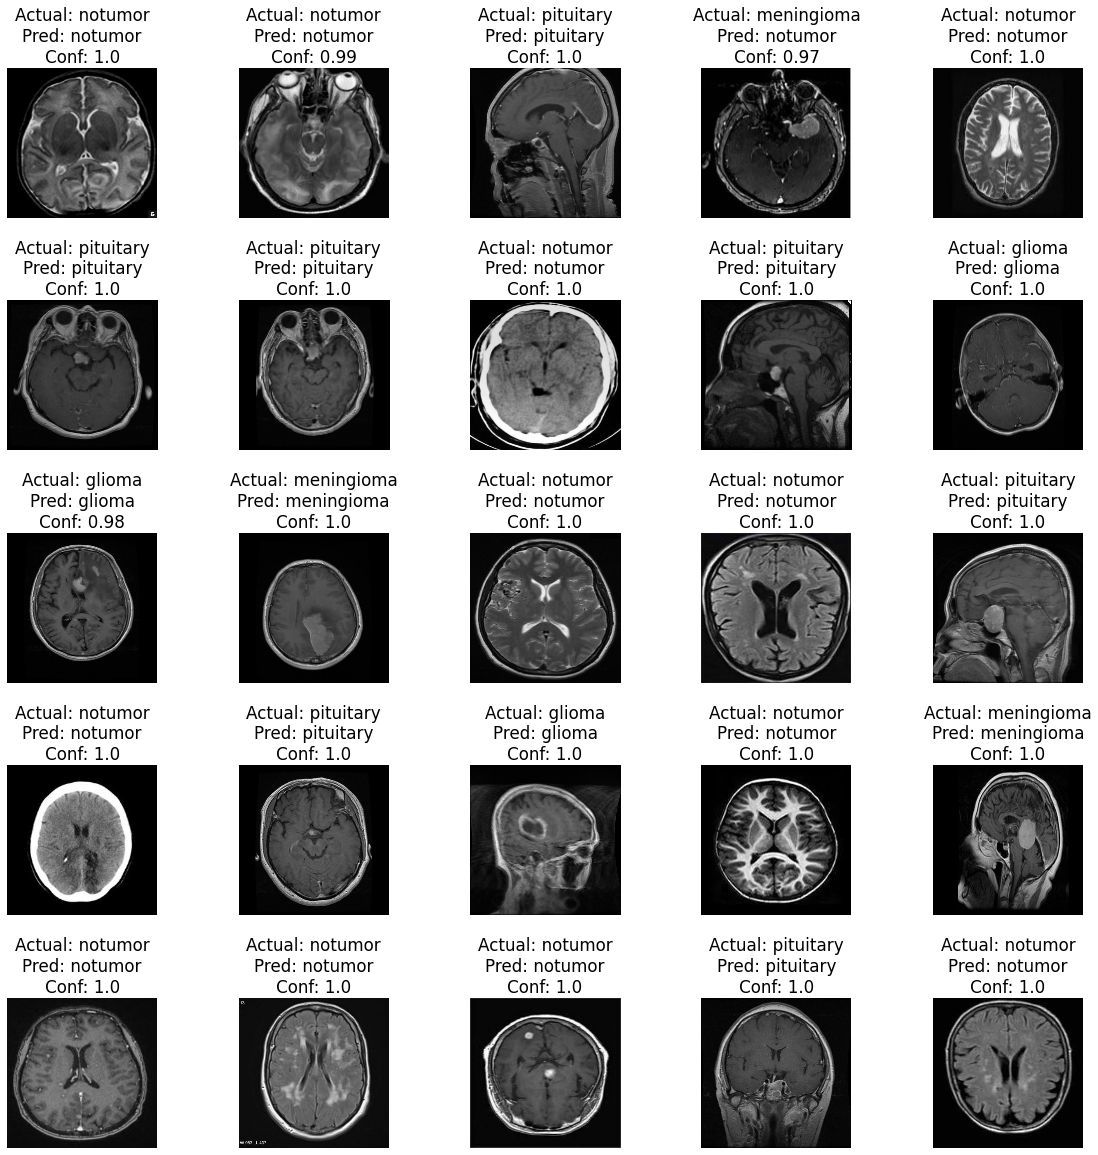

In [20]:
grid_width = 5
grid_height = 5
f, ax = plt.subplots(grid_width, grid_height)
f.set_size_inches(15, 15)

img_idx = 0
for i in range(0, grid_width):
    for j in range(0, grid_height):
        actual = actual_label[img_idx]
        predicted = preds[img_idx]
        confidence = round(test_predictions[img_idx][predicted], 2)
        ax[i][j].axis('off')
        ax[i][j].set_title('Actual: '+labels[actual]+'\nPred: '+labels[predicted] + '\nConf: ' +str(confidence))
        ax[i][j].imshow(X_test[img_idx])
        img_idx += 1

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.5, hspace=0.55)  